In [982]:
import numpy as np
import scipy
from scipy import linalg as la
import scipy.misc
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from numba import njit, prange
import sympy
import mpmath

# QR Decomposition

##

In [766]:
def qrd(A):
    m,n = np.shape(A)
    Q = np.copy(A)
    R = np.zeros((n,n))
    for i in range(n):
        R[i,i] = la.norm(Q[:,i]) 
        Q[:,i] = Q[:,i] / R[i,i]
        for j in range(i+1, n):
            R[i,j] = Q[:,j].T @ Q[:,i]
            Q[:,j] = Q[:,j] - R[i,j] * Q[:,i]
    return Q,R

In [767]:
def problem1_1():
    
    LB = -1e4 # lower bound for entries of A
    UB = 1e4 # upper bound for entries
    MAX_SIZE = 10 # upper bound on size of matrix
    
    rank_n = False
    while not rank_n:
        m = np.random.randint(1,MAX_SIZE+1)
        n = np.random.randint(1,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(m,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
    Q1,R1 = qrd(A)
    Q2,R2 = la.qr(A, mode="economic")
    
    verifyR = np.allclose(np.triu(R1), R1)
    verifyQ = np.allclose(Q1.T @ Q1, np.identity(n))
    verifyQR = np.allclose(Q1 @ R1, A)
    
    print("•  R is correct:",verifyR)
    print("•  Q is correct:",verifyQ)
    print("•  The QR Decomposition is correct:",verifyQR)
    
    print("\nMy Q:\n",Q1,"\n\nMy R:\n",R1,"\n\nScipy's Q:\n",
          Q2,"\n\nScipy's R:\n",R2)

In [768]:
problem1_1()

•  R is correct: True
•  Q is correct: True
•  The QR Decomposition is correct: True

My Q:
 [[ 0.6312998 ]
 [-0.01621734]
 [ 0.14307467]
 [-0.6794677 ]
 [ 0.34503747]] 

My R:
 [[10363.22025088]] 

Scipy's Q:
 [[-0.6312998 ]
 [ 0.01621734]
 [-0.14307467]
 [ 0.6794677 ]
 [-0.34503747]] 

Scipy's R:
 [[-10363.22025088]]


## 

In [771]:
def absdet(A):
    return abs(np.prod(np.diag(qrd(A)[1])))

In [774]:
def problem1_2():
    LB = -1 # lower bound for entries of A
    UB = 1 # upper bound for entries
    
    # a,b smaller to avoid roundoff error for large determinants
    
    MAX_SIZE = 10 # upper bound on size of A
    
    rank_n = False
    while not rank_n:
        n = np.random.randint(1,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(n,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
    
    absdet1 = round(absdet(A),5)
    absdet2 = round(abs(la.det(A)),5)
    
    print("•  The algorithm was correct:\t",(absdet1 == absdet2),
         "\n•  My |det(A)|:\t\t\t",absdet1,"\n•  Scipy's |det(A)|:\t\t",
          absdet2)

In [775]:
problem1_2()

•  The algorithm was correct:	 True 
•  My |det(A)|:			 1.01417 
•  Scipy's |det(A)|:		 1.01417


## 

In [415]:
def solve_linear_system(A,b):
    Q,R = qrd(A)
    y = Q.T @ b
    n = np.shape(A)[0]
    x = np.zeros(n)

    for i in range(n-1,-1,-1):
        x[i] = y[i]
        for j in range(i+1,n):
            x[i] = x[i] - R[i,j] * x[j]
        x[i] = x[i] / R[i,i]
    
    return x

In [437]:
def problem1_3():
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        n = np.random.randint(1,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(n,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
    
    b = (UB-LB) * np.random.rand(n) + LB
    
    x = solve_linear_system(A,b)
    
    print("x:",x)
    print("\n--> ACCURATE:",all(np.round(A @ x,5) == np.round(b,5)))

In [438]:
problem1_3()

x: [-2.16276632 -0.41584287]

--> ACCURATE: True


## 

In [776]:
def householder(A):
    m,n = np.shape(A)
    R = np.copy(A)
    Q = np.eye(m)
    sign = lambda x: 1 if x>=0 else -1
    for k in range(n):
        u = np.copy(R[k:,k])
        u[0] = u[0] + sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        R[k:,k:] = R[k:,k:] - np.outer(2*u, u.T @ R[k:,k:])
        Q[k:,:] = Q[k:,:] - np.outer(2*u, u.T @ Q[k:,:])
    
    return Q.T, R

In [777]:
def problem1_4():
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        m = np.random.randint(1,MAX_SIZE+1)
        n = np.random.randint(1,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(m,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
            
    QT,R = householder(A)
    
    print(" •  A shape:  ",np.shape(A),"\n",
           "•  Q.T shape:",np.shape(QT),"\n",
           "•  R shape:  ",np.shape(R),"\n")
    
    print("--> ACCURATE:",np.allclose((QT @ R),A))

In [778]:
problem1_4()

 •  A shape:   (9, 4) 
 •  Q.T shape: (9, 9) 
 •  R shape:   (9, 4) 

--> ACCURATE: True


## 

In [779]:
def hessenberg(A):
    m,n = np.shape(A)
    H = np.copy(A)
    Q = np.eye(m)
    sign = lambda x: 1 if x>=0 else -1
    for k in range(n-2):
        u = np.copy(H[k+1:,k])
        u[0] = u[0] + sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        H[k+1:,k:] = H[k+1:,k:] - np.outer(2*u, u.T @ H[k+1:,k:])
        H[:,k+1:] = H[:,k+1:] - 2 * np.outer(H[:,k+1:] @ u, u.T)
        Q[k+1:,:] = Q[k+1:,:] - np.outer(2*u, u.T @ Q[k+1:,:])
        
    return H, Q.T

In [780]:
def problem1_5():
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        n = np.random.randint(1,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(n,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
            
    H1,QT1 = hessenberg(A)
    H2,QT2 = la.hessenberg(A, calc_q = True)
    
    print("MY FUNCTION:")
    print("•  Verify H has all zeros below first subdiagonal:",
          np.allclose(np.triu(H1,-1),H1),"\n•  Verify Q @ H @ Q.T = A:",
          np.allclose(QT1 @ H1 @ QT1.T, A))
    
    print("\nSCIPY'S FUNCTION:")
    print("•  Verify H has all zeros below first subdiagonal:",
          np.allclose(np.triu(H2,-1),H2),"\n•  Verify Q @ H @ Q.T = A:",
          np.allclose(QT2 @ H2 @ QT2.T, A))

In [781]:
problem1_5() # mess around with QT, Q.T, and Q in problem1_5 if not getting true

MY FUNCTION:
•  Verify H has all zeros below first subdiagonal: True 
•  Verify Q @ H @ Q.T = A: True

SCIPY'S FUNCTION:
•  Verify H has all zeros below first subdiagonal: True 
•  Verify Q @ H @ Q.T = A: True


# Least Squares and Computing Eigenvalues

## 

In [579]:
def solve_normal_equations(A,b):

    Q,R = qrd(A.T)

    x = la.solve_triangular(R, Q.T@b)

    return x

In [491]:
def problem2_1():
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        m = np.random.randint(1,MAX_SIZE+1)
        n = np.random.randint(1,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(m,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
    
    b = (UB-LB) * np.random.rand(m) + LB
    
    x = solve_normal_equations(A,b)
    
    print("x:",x)
    print("\n--> ACCURATE:",np.allclose(A @ x, b))

In [492]:
problem2_1()

x: [-0.18569398 -0.38314783  0.69416316 -0.4249165   0.121046   -0.11408084
 -0.3452373 ]

--> ACCURATE: False


## 

In [588]:
def problem2_2():
    year, index = np.load("housing.npy").T
    A = year
    A = np.vstack((A, np.ones(len(year))))
    b = index
    
    β_1, β_0 = solve_normal_equations(A,b)
    
    plt.scatter(year, index, facecolors="none", edgecolors="k", s=12)
    plt.plot(year, year * β_1 + β_0, "r--")
    plt.title("Housing index regressed on year")
    plt.xlabel("Year (20xx)")
    plt.ylabel("Housing Index")
    
    plt.show()

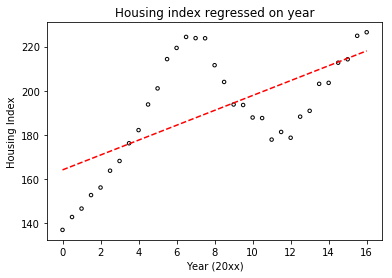

In [589]:
problem2_2()

## 

In [789]:
def problem2_3():
    degs = [3,6,9,12]
    styles = ["r","b","g","m"]
    year, index = np.load("housing.npy").T
    A = year
    A = np.vstack((year,np.ones(len(year))))
    b = index
    
    β_1, β_0 = solve_normal_equations(A,b)
    
    
    plt.scatter(year, index, facecolors="none", edgecolors="k", s=12)
    plt.plot(year, year * β_1 + β_0, "k--")
    plt.title("Housing index regressed on year")
    plt.xlabel("Year (20xx)")
    plt.ylabel("Housing Index")
    plt.show()
    
        
    
                              
    for n,i in enumerate(degs):
        plt.subplot(2,2,n+1)
        plt.scatter(year, index, facecolors="none", edgecolors="k", s=8)
        plt.plot(year, year * β_1 + β_0, "k--")
        plt.title(r"degree $\mathbf{"+str(i)+"}$ polynomial",size=10)
        plt.xticks([])
        plt.yticks([])
                              
        deglist = list(range(i+1))
        
        M = year[:, np.newaxis]**deglist
        coeffs = la.lstsq(M, b)[0]
        
        y = coeffs[0]
        for j in range(1,i+1):
            y += coeffs[j] * year**j
        plt.plot(year, y, styles[n])
    plt.suptitle(r"Plots using $\mathtt{scipy.linalg.lstsq()}$",size=14,y=1.02)
    plt.subplots_adjust(hspace=.2, wspace=.1)
    plt.show()
    
    
    
    

    for n,i in enumerate(degs):
        plt.subplot(2,2,n+1)
        plt.scatter(year, index, facecolors="none", edgecolors="k", s=8)
        plt.plot(year, year * β_1 + β_0, "k--")
        plt.title(r"degree $\mathbf{"+str(i)+"}$ polynomial",size=10)
        plt.xticks([])
        plt.yticks([])
        coeffs = np.polyfit(year, index, i)[::-1]
        y = coeffs[0]
        for j in range(1,i+1):
            y += coeffs[j] * year**j
        plt.plot(year, y, styles[n])
    plt.suptitle(r"Plots using $\mathtt{np.plolyfit()}$",size=14,y=1.02)
    plt.subplots_adjust(hspace=.2, wspace=.1)
    plt.show()

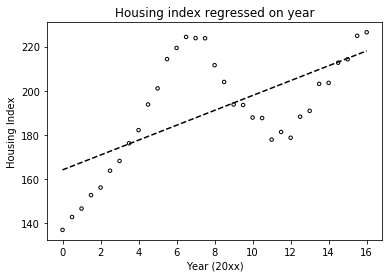

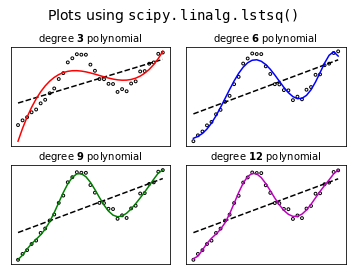

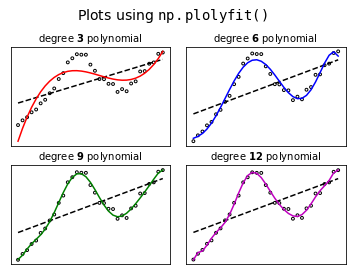

In [790]:
problem2_3()

## 

In [899]:
def problem2_4():
    x,y = np.load("ellipse.npy").T
    A = np.column_stack((x**2, x, x*y, y, y**2))
    b = np.ones_like(x)

    a,b,c,d,e = la.lstsq(A, b)[0]
    
    plot_ellipse(a,b,c,d,e)
    
    plt.plot(x, y, 'k.')
    plt.axis("equal")
    plt.show()
    

In [906]:
def plot_ellipse(a,b,c,d,e):
    '''
    ax^2 + bx + cxy + dy + ey^2 = 1
    ''' 
    theta = np.linspace(0, 2*np.pi, 200)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    A = a*(cos_t**2) + c*cos_t*sin_t + e*(sin_t**2)
    B = b*cos_t + d*sin_t
    r = (-B + np.sqrt(B**2 + 4*A)) / (2*A)
    plt.plot(r*cos_t, r*sin_t, "r--", lw=2)
    plt.gca().set_aspect("equal", "datalim")

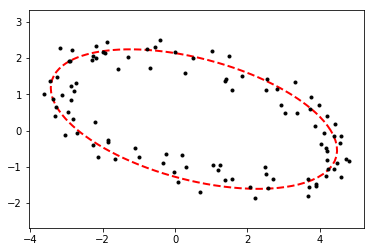

In [907]:
problem2_4()

## 

In [1020]:
def power_method(A, N, tol):
    m, n = A.shape
    x = np.random.random(size=n)
    x = x / la.norm(x)
    k = 0
    t = 1e8
    while (t > tol) and (k < N):
        x = A @ x
        x = x / la.norm(x)
        k += 1
    return x.T @ A @ x, x

In [1021]:
def problem2_5():
    LB = 1e-10
    UB = 10
    MAX_SIZE = 10

    rank_n = False
    while not rank_n:
        n = np.random.randint(2,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(n,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True

    evals, evecs = la.eig(A)
    loc = np.argmax(eigs)
    
    λ0, x0 = evals[loc], evecs[:,loc]
    
    print("       Scipy A@x == λ*x:",np.allclose(A @ x0, λ0 * x0))
    
    λ, x = power_method(A, 100, 1e-4)
    
    print("power_method A@x == λ*x:",np.allclose(A @ x, λ * x))

In [1022]:
problem2_5()

       Scipy A@x == λ*x: True
power_method A@x == λ*x: True


## 

In [1110]:
def qr_algo(A, N, tol):
    n = A.shape[0]
    S = la.hessenberg(A)
    
    for k in range(N):
        Q, R = qrd(S)
        S = R @ Q
    evals = []
    i = 0
    while i < n:
        if i == n - 1:
            evals.append(S[i, i])
        elif S[i + 1, i] < tol:
            evals.append(S[i, i])
        elif len(S[i:, i:]) == 2:
            λ1 = ((S[i, i] + S[i+1, i+1]) + cmath.sqrt((S[i, i] + S[i+1, i+1]) ** 2 
                                                      - 4 * (S[i, i] * S[i+1, i+1] - S[i, i+1] * S[i+1, i]))) / 2
            λ2 = ((S[i, i] + S[i+1, i+1]) - cmath.sqrt((S[i, i] + S[i+1, i+1]) ** 2 
                                                      - 4 * (S[i, i] * S[i+1, i+1] - S[i, i+1] * S[i+1, i]))) / 2
            evals.append(λ1, λ2)
            i += 1
        i += 1
        
    return evals

In [1111]:
def problem2_6():
    LB = 1e-10
    UB = 10
    MAX_SIZE = 10

    rank_n = False
    while not rank_n:
        n = np.random.randint(2,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(n,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
            
    print("Scipy's e-vals:")
    print(la.eig(A + A.T)[:-1])

    
    print("\nMy e-vals:")
    print(qr_algo(A + A.T, 1000, 1e-8))

In [1112]:
problem2_6()

Scipy's e-vals:
(array([59.94613458+0.j, 18.82900741+0.j, -8.60436854+0.j, -5.43809062+0.j,
        1.29177465+0.j,  8.41848897+0.j]),)

My e-vals:
[59.94613458346843, 18.829007410440433, -8.60436853780165, 8.418488966739073, -5.438090622342103, 1.2917746487433845]


The eigenvalues are the same!

# SVD and Image Compression

## 

In [782]:
def compact_svd(A, tol=1e-4):
    AH = A.conj().T
    λ, V = la.eig(AH @ A)
    σ = np.sqrt(λ)
    
    V = V[:,np.argsort(σ)[::-1]]
    σ = np.sort(σ)[::-1]

    
    r = 0
    for i in σ:
        if i>tol:
            r+=1
    
    σ_1 = σ[:r]
    V_1 = V[:,:r]
    U_1 = A @ V_1 / σ_1
    
    VH_1 = V_1.conj().T
    
    return U_1, σ_1, VH_1


In [783]:
def problem3_1():
    
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        m = np.random.randint(2,MAX_SIZE+1)
        n = np.random.randint(2,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(m,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True   
        
    U0, σ0, VH0 = la.svd(A, full_matrices=False)
    
    print("--- BUILT-IN SVD ---\n")
    
    print(
        " •  U.shape, σ.shape, VH.shape:\n   ",
        U0.shape, σ0.shape, VH0.shape,"\n")

    print(
        
        " •  Verify U and VH are orthonormal:",
        np.allclose(U0.T @ U0, np.identity(n)),
        np.allclose(VH0.T @ VH0,np.identity(n)),"\n\n",

        "•  Verify U @ σ @ VH = A:",
        np.allclose(U0 @ np.diag(σ0) @ VH0, A),"\n\n",

        "•  Verify the rank is correct:",
        np.linalg.matrix_rank(A) == len(σ0))
    
    
    print("\n---  COMPACT SVD  ---\n")
    
    
    U, σ, VH = compact_svd(A, tol = 1e-15)
    print(
        " •  U.shape, σ.shape, VH.shape:\n   ",
        U.shape, σ.shape, VH.shape,"\n")

    print(
        
        " •  Verify U and VH are orthonormal:",
        np.allclose(U.T @ U, np.identity(n)),
        np.allclose(VH.T @ VH,np.identity(n)),"\n")

       
    print(
        " •  Verify U @ σ @ VH = A:",
        np.allclose(U @ np.diag(σ) @ VH, A),"\n\n",

        "•  Verify the rank is correct:",
        np.linalg.matrix_rank(A) == len(σ))
    

In [784]:
problem3_1()

--- BUILT-IN SVD ---

 •  U.shape, σ.shape, VH.shape:
    (10, 4) (4,) (4, 4) 

 •  Verify U and VH are orthonormal: True True 

 •  Verify U @ σ @ VH = A: True 

 •  Verify the rank is correct: True

---  COMPACT SVD  ---

 •  U.shape, σ.shape, VH.shape:
    (10, 4) (4,) (4, 4) 

 •  Verify U and VH are orthonormal: True True 

 •  Verify U @ σ @ VH = A: True 

 •  Verify the rank is correct: True


## 

In [306]:
def A_to_S(A):
    θ = np.linspace(0, 2 * np.pi, 200)
    S = np.vstack([np.cos(θ), np.sin(θ)])    
    return S

In [325]:
def problem3_2():
    LB = -10
    UB = 10    
    A = (UB - LB) * np.random.rand(2,2) + LB
    
    S = A_to_S(A)
    
    E = np.array([[1, 0, 0],
                  [0, 0, 1]])
    
    U, σ, V = la.svd(A)
    Σ = np.diag(σ)
    
    plt.subplot(221)
    plt.plot(S[0], S[1])
    plt.plot(E[0], E[1])
    plt.title(r"$S$")
    plt.axis("equal")
    
    plt.subplot(222)
    plt.plot((V @ S)[0], (V @ S)[1])
    plt.plot((V @ E)[0], (V @ E)[1])
    plt.title(r"$V^{\mathsf{H}}S$")
    plt.axis("equal")
    
    plt.subplot(223)
    plt.plot((Σ @ V @ S)[0], (Σ @ V @ S)[1])
    plt.plot((Σ @ V @ E)[0], (Σ @ V @ E)[1])
    plt.title(r"$\Sigma V^{\mathsf{H}}S$")
    plt.axis("equal")
    
    plt.subplot(224)
    plt.plot((U @ Σ @ V @ S)[0], (U @ Σ @ V @ S)[1])
    plt.plot((U @ Σ @ V @ E)[0], (U @ Σ @ V @ E)[1])
    plt.title(r"$U \Sigma V^{\mathsf{H}}S$")
    plt.axis("equal")
        
        
    plt.subplots_adjust(hspace=.5, wspace=.2)
    plt.show()

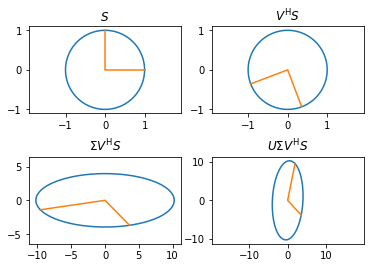

In [328]:
problem3_2()

## 

In [340]:
def compact_svd_2(A, s):
    
    m,n = np.shape(A)
    
    if s>np.linalg.matrix_rank(A):
        raise ValueError("s is greater than the number of nonzero singular values of A.")
        
    vals = m*s + n*s + s
    
    U,σ,V = la.svd(A)
    U_s = U[:,:s]
    σ_s = σ[:s]
    V_s = V[:s,:]
    
    return U_s @ np.diag(σ_s) @ V_s, vals

In [345]:
def problem3_3():
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        m = np.random.randint(2,MAX_SIZE+1)
        n = np.random.randint(2,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(m,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True  
    
    s = np.random.randint(min(m,n),max(m,n)+1)
    
    a,b = compact_svd_2(A,s)
    
    print("U_s @ diag(σ_s) @ V_s:\n\n",a,"\n\nvals:",b)

In [353]:
problem3_3()

U_s @ diag(σ_s) @ V_s:

 [[ 7.72364074  8.13857641 -9.77569061  9.12699429]
 [ 6.92178331 -3.97026793 -9.19867206  5.49575643]
 [-0.81925435  1.52811771 -2.84979319 -3.78509506]
 [-4.65441984  3.70018924 -1.71173774  8.55567942]] 

vals: 36


## 

In [354]:
def compact_svd_3(A, ε=0.1): 
    U,σ,V = la.svd(A)
    
    if ε < min(σ):
        raise ValueError("ε is less than or equal to the smallest singular value of A")    
    
    s = len(σ[σ>ε])

    U_s = U[:,:s]
    σ_s = σ[:s]
    V_s = V[:s,:]
    
    return U_s @ np.diag(σ_s) @ V_s

In [389]:
def problem3_4():
    
    ε = 0.4
    
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        m = np.random.randint(2,MAX_SIZE+1)
        n = np.random.randint(2,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(m,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
    
    print("A:\n",A,"\n\n")
    print("proper singular vals of A:\n",la.svd(A)[1],"\n\n")
    print("my singular vals of A:\n",compact_svd_3(A, ε=ε),"\n\n")
    print("normed differece:\n",la.norm(A - compact_svd_3(A,ε=ε)))

In [395]:
problem3_4()

A:
 [[-8.14008872  8.8974224  -0.20543243  9.01534961 -7.55091274  9.204904  ]
 [ 1.74478595  4.77436014  6.87386709 -0.82403186  1.09794414  6.61596462]
 [ 2.03170595 -6.78766454  8.39982062 -8.90647696  3.87701378  8.66322419]
 [-4.28915763 -4.94207401 -5.93352352 -5.24978438 -7.58635383  1.97710859]
 [ 1.16450135  7.80141351 -4.44290169  8.03013323 -9.44867885  8.05407065]
 [-9.53613868  1.68859368  1.98162728  2.04886406  6.98879612  8.2807711 ]
 [-7.3645293  -6.74281246 -6.12340625 -6.3796139  -6.88362993  7.96240487]] 


proper singular vals of A:
 [26.7263637  21.83089036 19.63344719 12.35442399  4.31631604  2.32914168] 


my singular vals of A:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 


normed differece:
 41.86938996792117


## 

In [412]:
def compress(file, s):
    
    im = plt.imread(file)/255
    
    if im.ndim == 3:
        C=[]
        V=0
        for i in range(3):
            col = im[:,:,i]
            col_s,v = compact_svd(col, s)
            V+=v
            col_s[col_s<0] = 0
            col_s[col_s>1] = 1
            C.append(col_s)
        return np.dstack(C),V
            
    elif im.ndim == 2:
        im_s,v = compact_svd(im, s)
        im_s[im_s<0] = 0
        im_s[im_s>1] = 1
        return im_s, v

In [419]:
def problem3_5():
    
    im1 = plt.imread("hubble.jpg")/255
    im1_c, v1_c = compress("hubble.jpg",5)

    plt.subplot(221).imshow(im1)
    plt.subplot(222).imshow(im1_c)
    
    im2 = plt.imread("puppy.jpg")/255
    im2_c, v2_c = compress("puppy.jpg",25)
    
    plt.subplot(223).imshow(im2, cmap="gray")
    plt.subplot(224).imshow(im2_c, cmap="gray")
    plt.show()
    

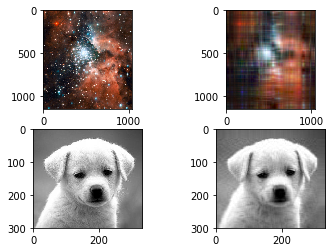

In [420]:
problem3_5()

# The Drazin Inverse

## 

In [785]:
def check_drazin(A, k, A_D):
    return (
    np.allclose(A @ A_D, A_D @ A) and 
    np.allclose(np.linalg.matrix_power(A, k+1) 
        @ A_D, np.linalg.matrix_power(A, k)) and 
    np.allclose(A_D @ A @ A_D, A_D)
    )

In [786]:
def problem4_1():
    
    A = np.array([[1, 3, 0, 0],
                  [0, 1, 3, 0],
                  [0, 0, 1, 3],
                  [0, 0, 0, 0]])
    k_A = 1
    A_D = np.array([[1, -3, 9, 81],
                    [0, 1, -3, -18],
                    [0, 0, 1, 3],
                    [0, 0, 0, 0]])
    print("•  A^D is the Drazin inverse of A for index "+
          str(k_A)+":",check_drazin(A, k_A, A_D),"\n")
    
    
    
    B = np.array([[1, 1, 3],
                  [5, 2, 6],
                  [-2, -1, -3]])
    k_B = 3
    B_D = np.zeros((3, 3))
    print("•  B^D is the Drazin inverse of B for index "+
          str(k_B)+":",check_drazin(B, k_B, B_D))

In [787]:
problem4_1()

•  A^D is the Drazin inverse of A for index 1: True 

•  B^D is the Drazin inverse of B for index 3: True


## 

In [788]:
def compute_drazin(A, k, tol=1e-3):
    
    n=np.shape(A)[0]
    
    gter = lambda x: (
        abs(x) > tol) # "greater than" function
    
    leq = lambda x: (
        abs(x) <= tol) # "less than or equal to" function
        
    Q_1,S,k_1 = la.schur(A, sort=gter) # using the lambda function
    Q_2,T,k_2 = la.schur(A, sort=leq) # using the lambda function
    
    U = np.hstack([S[:,:k_1], T[:,:(n-k_1)]])
    U_inv = np.linalg.inv(U)
    V = U_inv @ A @ U
    Z = np.zeros((n,n))
    
    if k!=0:
        M_inv = np.linalg.inv(V[:k_1,:k_1])
        Z[:k_1,:k_1] = M_inv
    
    return U @ Z @ U_inv

In [789]:
def problem4_2():
    
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        n = np.random.randint(2,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(n,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
        
    k_A = 5
    A_D = compute_drazin(A, k_A, tol=1e-3)
    
    print("•  A^D @ A:\n",np.round(np.abs( A_D @ A )),"\n")
    
    print("•  A^D is the Drazin inverse of A for index "+
          str(k_A)+":",check_drazin(A, k_A, A_D))

In [790]:
problem4_2()

•  A^D @ A:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

•  A^D is the Drazin inverse of A for index 5: True


## 

In [791]:
def resistance(A):
    
    n = A.shape[0]
    
    D = np.diag(A.sum(axis=1))
    
    L = D-A
    
    R = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            L_tilde = L.copy()
            L_tilde[j,:] = np.eye(n)[j]
            L_tilde = compute_drazin(L_tilde, k=5, tol=1e-6)
            if i!=j: R[i,j] = L_tilde[i,i]
    
    return R

In [792]:
def problem4_3():
    
    A_1 = np.array([[0, 1, 0, 0], 
                   [1, 0, 1, 0], 
                   [0, 1, 0, 1], 
                   [0, 0, 1, 0]])
    
    A_2 = np.array([[0, 1], 
                   [1, 0]])
    
    print(
        "•  Resistence matrix for A_1 =\n",A_1,":\n\n",
        np.round(resistance(A_1)),"\n\n",
        "•  Resistence matrix for A_2 =\n",A_2,":\n\n",
        np.round(resistance(A_2))
    )

In [793]:
problem4_3()

•  Resistence matrix for A_1 =
 [[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]] :

 [[0. 1. 2. 3.]
 [1. 0. 1. 2.]
 [2. 1. 0. 1.]
 [3. 2. 1. 0.]] 

 •  Resistence matrix for A_2 =
 [[0 1]
 [1 0]] :

 [[0. 1.]
 [1. 0.]]


## 

In [794]:
class LinkPredictor:
    
    def __init__(self, file):
        
        self.file = file
        
        nodes = []
        with open("social_network.csv","r") as f:
            for i in f:
                nodes.append(i.strip().split(","))
        nodes = np.array(nodes)
        names = np.unique(nodes)
        
        names_d = dict(zip(names, range(len(names))))
        nodes_d = np.array( [ [ names_d[i], names_d[j]] 
                                    for i,j in nodes[:,]     ] )
        A = np.zeros((len(names),len(names)))

        for e in nodes_d:
            i,j = e
            A[i,j] = 1
            A[j,i] = 1
            
        self.A, self.names, self.R = A, names, resistance(A)

    def predict_link(self, node=None):
        
        R,A,names = self.R,self.A,self.names
        R[A==1] = 0
        
        if node == None:
            minarg = np.argwhere(R == np.min(R[R>0])).flatten()
            return names[minarg[0]],names[minarg[1]]
        
        elif node.isalpha():
            if node not in names: raise ValueError("Not in the network")
                
            R_b = R[:,np.argwhere(names == node)]
            minarg = np.argwhere(R_b == np.min(R_b[R_b>0])).flatten()
            return node,names[minarg[0]]
        
    def add_link(self, node_1, node_2):
        
        names = self.names
        
        if ((node_1 not in names) or 
            (node_2 not in names)):
            raise ValueError("Not in the network")
            
        self.A[np.argwhere(names==node_1),np.argwhere(names==node_2)],\
        self.A[np.argwhere(names==node_2),np.argwhere(names==node_1)],\
        self.R = 1,1,resistance(self.A)

In [795]:
def problem4_4():
    
    net = LinkPredictor("social_network.csv")
    
    print("•  Should be Oliver, Emily:",
          str(net.predict_link()[0])+",",
          net.predict_link()[1],"\n")
    
    print("•  Should be Carol:",
        net.predict_link("Melanie")[1],"\n")
    
    print("•  Should be Sonia:",
        net.predict_link("Alan")[1],"\n")
    
    net.add_link("Sonia", "Alan")
    print("•  Should be Piers:",
        net.predict_link("Alan")[1],"\n")
    
    net.add_link("Piers", "Alan")
    print("•  Should be Abigail:",
        net.predict_link("Alan")[1])

In [796]:
problem4_4()

•  Should be Oliver, Emily: Oliver, Emily 

•  Should be Carol: Carol 

•  Should be Sonia: Sonia 

•  Should be Piers: Piers 

•  Should be Abigail: Abigail


## 

See Problem 4 above for the implemented methods and tests.

# The PageRank Algorithm

## 

In [582]:
def adj(file, N):
    A = np.zeros((N, N))
    
    nodes = []
    with open(file,"r") as f:
        for v in f:
            try: nodes.append(list(map(int,v.strip().split())))
            except: pass
    for i in range(N):
        for j in range(N):
            if [i,j] in nodes:
                A[i,j]=1
    return dok_matrix(A).toarray()

In [583]:
def problem5_1():
    print(adj("matrix.txt",8))

In [584]:
problem5_1()

[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


## 

In [602]:
def K(A,N):
    A[A.sum(axis=1)==0,:] = np.ones(N)
    return A.T / A.sum(axis=1)

In [603]:
def problem5_2():
    print(K(adj("matrix.txt",8),8))

In [604]:
problem5_2()

[[0.         1.         0.125      0.33333333 0.33333333 0.5
  1.         1.        ]
 [0.         0.         0.125      0.         0.         0.
  0.         0.        ]
 [0.         0.         0.125      0.33333333 0.         0.
  0.         0.        ]
 [0.         0.         0.125      0.         0.         0.
  0.         0.        ]
 [0.         0.         0.125      0.         0.         0.
  0.         0.        ]
 [0.         0.         0.125      0.         0.33333333 0.
  0.         0.        ]
 [0.         0.         0.125      0.33333333 0.33333333 0.5
  0.         0.        ]
 [1.         0.         0.125      0.         0.         0.
  0.         0.        ]]


## 

In [700]:
def page_rank_ss(A, N=None, d=0.85, tol=1e-5):
    
    if N == None: N = A.shape[0]
        
    A = A[:N+1,:N+1]
        
    pr_ss = np.ones(N)/np.ones(N).sum()
    norm=100
    while norm>tol:
        pr_ss_pr = d * K(A,N)@pr_ss + ((1-d)/N) * np.ones(N)
        norm = la.norm(pr_ss - pr_ss_pr)
        pr_ss = pr_ss_pr
        
    return pr_ss

In [701]:
def problem5_3():
    print(page_rank_ss(adj("matrix.txt",8)))

In [702]:
problem5_3()

[0.43868966 0.02171029 0.02786154 0.02171029 0.02171029 0.02786154
 0.04585394 0.39460246]


## 

In [637]:
def page_rank_ss_2(A, N=None, d=0.85, tol=1e-5):
    
    if N == None: N = A.shape[0]
    
    A = A[:N+1,:N+1]
            
    evals,evecs = la.eig(d * K(A,N) + ((1-d)/N) * np.ones((N,N)))
            
    return evecs[:,evals.argmax()]

In [638]:
def problem5_4():
    print(page_rank_ss_2(adj("matrix.txt",8)))

In [639]:
problem5_4()

[-0.73812911 -0.03652896 -0.04687883 -0.03652896 -0.03652896 -0.04687883
 -0.07715221 -0.66393871]


## 

In [729]:
def ncaa():
    
    win_loss = []
    with open("ncaa2013.csv","r") as f:
        f.readline()
        for e in f: win_loss.append(e.strip().split(","))
    win_loss = np.array(win_loss)
    
    
    teams = np.unique(win_loss.flatten())
    
    teams_d = dict(zip(teams,range(len(teams))))
    
    
    wins_losses = np.array([[teams_d[win], teams_d[loss]] for win, loss in win_loss[:,]])
    
    return (teams, wins_losses)

In [734]:
def problem5_5():
    
    mx = np.zeros((len(ncaa()[0]),len(ncaa()[0])))
    
    for i in ncaa()[1]:
        mx[i[0], i[1]] = 1
        
    print("I could not get this to work :( \n",
        ncaa()[0][page_rank_ss(mx,d=.3).argsort()[-5:][::-1]])

In [735]:
problem5_5()

I could not get this to work :( 
 ['Coppin St' 'Longwood' 'Grambling' 'MD E Shore' 'Maine']


# Conditioning and Stability

## 

In [757]:
def condition_number(A):
    return (np.inf if min(la.svdvals(A))==0 else max(la.svdvals(A))/min(la.svdvals(A)))

In [762]:
def problem6_1():
    
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        n = np.random.randint(2,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(n,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True
    
    print("•  Condition number:",condition_number(A),"\n")
    print("•  According to Numpy:",np.linalg.cond(A),"\n")
    print("•  For an identity matrix:",condition_number(np.eye(n)))

In [763]:
problem6_1()

•  Condition number: 63.53482183755394 

•  According to Numpy: 63.53482183755394 

•  For an identity matrix: 1.0


## 

In [896]:
def perturb(N=20):
    
    roots = np.arange(1, N)
    
    x,i = sympy.symbols("x"),sympy.symbols("i")
    coeffs = np.array(sympy.poly_from_expr(sympy.product(x-i, (i,1,N-1)))[0].all_coeffs())    
    
    for i in range(100):
        r = np.random.normal(loc=1,scale=1e-10,size=N)

        coeffs_pr = coeffs*r
        roots_pr = np.roots(np.poly1d(coeffs_pr))
        roots,roots_pr = np.sort(roots),np.sort(roots_pr)
        plt.scatter(roots_pr.real,roots_pr.imag,marker=",",color="k",s=2,label="Perturbed")
    
    plt.plot(roots,np.zeros(N-1),"bo",label="Original")
        
    plt.xlabel("Real Axis")
    plt.ylabel("Imaginary Axis")
    plt.legend(["Original", "Perturbed"])
    plt.show()
    
    print("•  Absolute:",la.norm(roots_pr-roots,np.inf)/la.norm(r))
    print("•  Relative:",la.norm(roots, np.inf)/la.norm(roots_pr,np.inf))

In [897]:
def problem6_2():
    perturb()

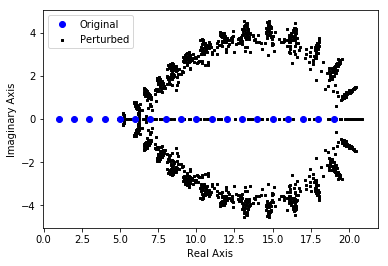

•  Absolute: 0.8999654602202808
•  Relative: 0.951197269595549


In [898]:
problem6_2()

## 

In [915]:
def condition_number_2(A):
    re,im = np.random.normal(0, 1e-10, A.shape),np.random.normal(0, 1e-10, A.shape)

    evals,evals_tilde = la.eigvals(A), la.eigvals(A + re + 1j*im)

    return (la.norm(evals-evals_tilde)/la.norm(re + 1j*im),
            (la.norm(A)/la.norm(evals)) * (la.norm(evals-evals_tilde)/la.norm(re + 1j*im)))

In [916]:
def problem6_3():
    
    LB = -10
    UB = 10
    MAX_SIZE = 10
    
    rank_n = False
    while not rank_n:
        n = np.random.randint(2,MAX_SIZE+1)
        A = (UB - LB) * np.random.rand(n,n) + LB
        if np.linalg.matrix_rank(A) == n:
            rank_n = True    
    
    print("Absolute, Relative:",condition_number_2(A))

In [917]:
problem6_3()

Absolute, Relative: (24192357342.692562, 41377870928.61217)


## 

In [932]:
def relative_condition_number_plot(bounds=list, res=int):
    
    X,Y = np.meshgrid(np.linspace(bounds[0],bounds[1],res), 
                      np.linspace(bounds[2],bounds[3],res))
    
    nums = np.empty((res, res))
    for i in range(len(np.linspace(bounds[0],bounds[1],res))):
        for j in range(len(np.linspace(bounds[2],bounds[3],res))):
            A=np.array([[1,np.linspace(bounds[0],bounds[1],res)[i]],
                        [np.linspace(bounds[0],bounds[1],res)[j],1]])
            nums[i,j]=condition_number_2(A)[1]
                                
    plt.pcolormesh(X,Y,nums,cmap="gray_r")
    plt.colorbar()
    plt.show()

In [933]:
def problem6_4():
    relative_condition_number_plot([-100,100,-100,100],200)

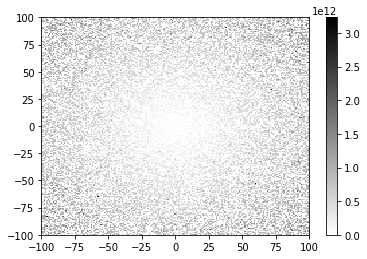

In [934]:
problem6_4()

## 

In [965]:
def poly(n):   
    
    x,y = np.load("stability_data.npy").T
    A = np.vander(x,n+1)
    
    x_inv = la.inv(A.T@A)@A.T@y
    error_inv = la.norm(A@x_inv-y)
    print("Inverse Forward Error:",error_inv)
    
    Q,R = la.qr(A, mode="economic")
    x_qr = la.solve_triangular(R,Q.T@y)
    error_qr = la.norm(A@x_qr-y)
    print("QR Forward Error:",error_qr)
    
    plt.plot(x,np.polyval(x_inv,x),label="Normal Equations")
    plt.plot(x,np.polyval(x_qr,x),label="QR Solver")
    plt.plot(x,y,"k.")
    plt.legend()
    plt.show()

In [966]:
def problem6_5():
    for i in range(5,25,5):
        poly(i)

Inverse Forward Error: 4.854970503107442
QR Forward Error: 4.85497050310744


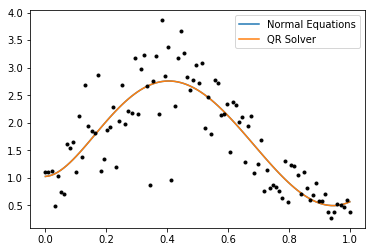

Inverse Forward Error: 4.6446869902282035
QR Forward Error: 4.644309587544681


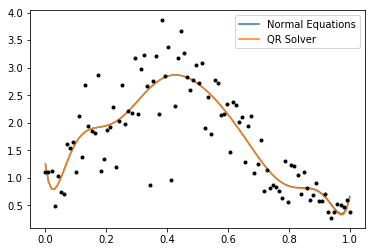

Inverse Forward Error: 21.495620902404788
QR Forward Error: 4.527556122356962


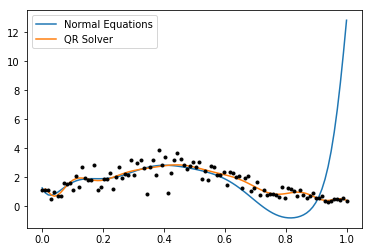

Inverse Forward Error: 183.0698894317729
QR Forward Error: 4.46208697902859


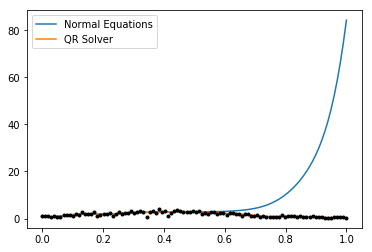

In [967]:
problem6_5()

## 

In [986]:
def relative_forward_error():
    

    n_list = range(5, 55, 5)
    error_list = np.empty(10)
    x = sympy.symbols("x")
    for j in range(len(n_list)):
        i = sympy.N(sympy.integrate(x**n_list[j]*sympy.exp(x-1), (x,0,1)))
        error_list[j] = np.abs(i - ((-1)**n_list[j] * 
            sympy.subfactorial(n_list[j]) + (-1)**(n_list[j]+1) * 
            sympy.factorial(n_list[j]) / mpmath.e))
        
    plt.plot(np.log(error_list))
    plt.show()

In [987]:
def problem6_6():
    relative_forward_error()

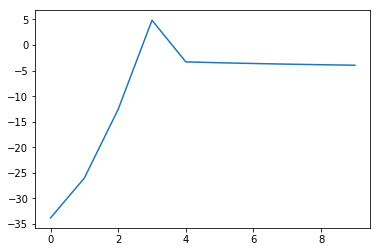

In [988]:
problem6_6()